In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import warnings

warnings.filterwarnings(action="ignore")


In [34]:
train = pd.read_csv('/data/ephemeral/data/train_data.csv')
test = pd.read_csv('/data/ephemeral/data/test_data.csv')

df = pd.concat([train, test])
df = df.reset_index(drop = True)

df["Timestamp"] = pd.to_datetime(df["Timestamp"])

결론 

In [81]:
# 정답률에 유의미한 차이가 있는 month, weekday, hour에 대해 feature 추가 
df['month'] = df['Timestamp'].dt.month # 1~12 O
df['weekday'] = df['Timestamp'].dt.weekday # 0~6 O
df['hour'] = df['Timestamp'].dt.hour # 0~23 O

# assessmentItemID와 testId에 대한 대분류 feature 추가
df['first3'] = df['assessmentItemID'].apply(lambda x : x[2]).astype(int) # 010 ~ 090 O
df['mid3'] = df['assessmentItemID'].apply(lambda x : x[4:7]).astype(int) # 001~198 X
df['last3'] = df['assessmentItemID'].apply(lambda x : x[-3:]).astype(int) # 문항 번호 X

In [82]:
def percentile(s):
    return np.sum(s) / len(s)

In [107]:
def graph_plot(df) : 
    fig, ax1 = plt.subplots()

    ax1.plot(df.index, df[df.columns[0]])
    ax1.set_ylabel(df.columns[0], color = 'blue')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[df.columns[1]], color = 'red')
    ax2.set_ylabel(df.columns[1], color = 'red')

    plt.show()

In [137]:
def graph_hist(df, str1, int1) : 
    fig, ax = plt.subplots()
    df[df['answerCode'] == 0][str1].hist(
        bins=int1, ax=ax, alpha=0.7, stacked=True, density=1, label = 'answer = 0'
    )
    df[df['answerCode'] == 1][str1].hist(
        bins=int1, ax=ax, alpha=0.7, stacked=True, density=1, label = 'answer = 1'
    )

    ax.legend()

testId, assessmentItemID에 대한 EDA

In [84]:
assess_first3 = df['assessmentItemID'].apply(lambda x : x[1:4]) # 1~9
assess_mid3 = df['assessmentItemID'].apply(lambda x : x[4:7])
assess_last3 = df['assessmentItemID'].apply(lambda x : x[-3:]) # 1~13

assess_mid3.value_counts()

assessmentItemID
017    20000
009    19550
011    19000
003    18900
007    18800
       ...  
180     4200
197     3300
194     2800
196     1450
198     1050
Name: count, Length: 198, dtype: int64

In [85]:
test_first3 = df['testId'].apply(lambda x : x[1:4]) # = assess_first3
test_mid3 = df['testId'].apply(lambda x : x[4:7]) # 0
test_last3 = df['testId'].apply(lambda x : x[-3:]) # = assess_mid3

test_last3.value_counts()

testId
017    20000
009    19550
011    19000
003    18900
007    18800
       ...  
180     4200
197     3300
194     2800
196     1450
198     1050
Name: count, Length: 198, dtype: int64

assessmentItemID = 문제 번호 = testId + 문항 번호 (3자리) = (first3 + mid3) + last3

각 3자리에 따른 정답률 변동..?

1 last3는 시험지 내 번호 => 정답률에 큰 변화는 없을 것이다. 

2 testId는 크게 first3 => mid3로 나뉜다 

2.1 first3는 학년? 과정? 등 큰 단위의 분류? => 9가지 분류

2.2 mid3는 과목, 단원 등 first3 내 작은 단위의 분류?

=> 198가지 분류, 전체적으로 모든 first3에 190개 이상씩 들어있음

=> 전체적으로 해당되는 분류...? 단원 번호 같은 느낌?

In [86]:
df.sample(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,weekday,hour,first3,mid3,last3
2382789,1569,A020126001,A020000126,1,2020-10-13 09:25:46,8019,10,1,9,2,126,1
2081813,4658,A050124003,A050000124,1,2020-10-01 07:18:35,5271,10,3,7,5,124,3
2416950,2005,A010092006,A010000092,0,2020-07-13 10:06:54,6556,7,0,10,1,92,6
1858753,3577,A050074002,A050000074,1,2020-02-13 10:01:31,5258,2,3,10,5,74,2
325854,437,A030056003,A030000056,0,2020-06-26 02:25:35,373,6,4,2,3,56,3
1366425,2234,A010035003,A010000035,1,2020-08-07 09:21:56,7595,8,4,9,1,35,3
1202870,1879,A010069004,A010000069,1,2020-07-01 05:50:58,6453,7,2,5,1,69,4
1436258,2386,A070048003,A070000048,0,2020-06-23 21:32:27,9161,6,1,21,7,48,3
1789549,3332,A070079001,A070000079,0,2020-08-06 21:19:38,9187,8,3,21,7,79,1
888985,1306,A020186003,A020000186,0,2020-09-01 13:14:40,8095,9,1,13,2,186,3


In [112]:
first3_groupby = df.groupby(df["first3"]).agg(
    {
        "first3": "count",
        "answerCode": percentile,
    }
)

first3_groupby
# first3가 커질수록 전체적으로 정답률은 감소 

,first3,answerCode
first3,,
1,303750,0.801241
2,297350,0.737515
3,303450,0.701733
4,300500,0.679714
5,306400,0.658649
6,296350,0.711898
7,315300,0.521167
8,271950,0.500224
9,131650,0.454470


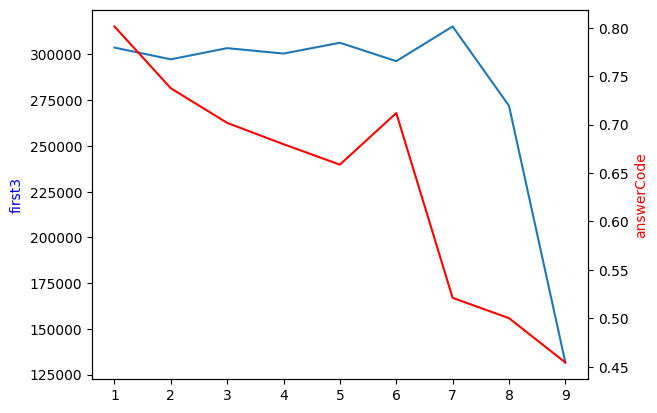

In [113]:
graph_plot(first3_groupby)

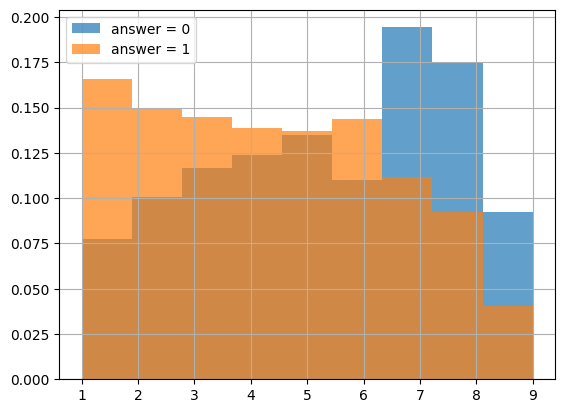

In [138]:
graph_hist(df, 'first3', len(first3_groupby))

In [116]:
mid3_groupby = df.groupby(df["mid3"]).agg(
    {
        "mid3": "count",
        "answerCode": percentile,
    }
)

mid3_groupby
# mid3별 큰 정답률 차이는 없어보이나 특정 mid3에서 정답률 차이가 유의미함.

,mid3,answerCode
mid3,,
1,16750,0.708478
2,13900,0.777266
3,18900,0.627090
4,13700,0.683066
5,18200,0.620000
...,...,...
194,2800,0.688214
195,4850,0.835052
196,1450,0.889655


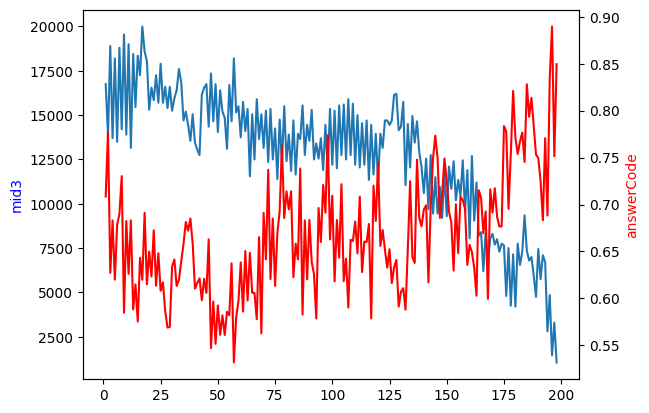

In [117]:
graph_plot(mid3_groupby)

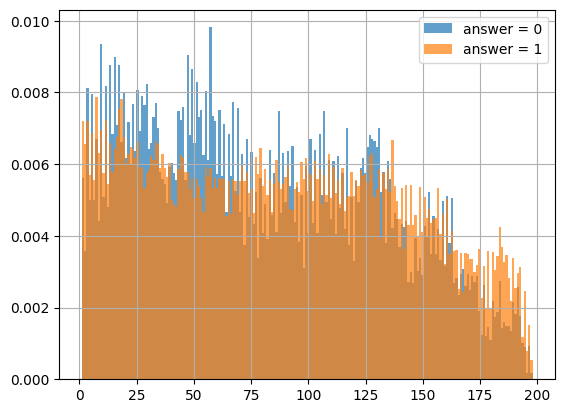

In [139]:
graph_hist(df, 'mid3', len(mid3_groupby))

In [145]:
mid3_groupby

,mid3,answerCode
mid3,,
1,16750,0.708478
2,13900,0.777266
3,18900,0.627090
4,13700,0.683066
5,18200,0.620000
...,...,...
194,2800,0.688214
195,4850,0.835052
196,1450,0.889655


Timestamp에 대한 EDA

In [88]:
year = df.groupby(df["Timestamp"].dt.year).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

year
# 년도에 따른 정답률은 신경쓰지 말자

,assessmentItemID,answerCode
Timestamp,,
2019,24,0.833333
2020,2526676,0.654150


In [89]:
month = df.groupby(df["Timestamp"].dt.month).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

month
# 월에 따른 차이가 크다

,assessmentItemID,answerCode
Timestamp,,
1,41777,0.706633
2,87957,0.686131
3,195207,0.681989
4,197461,0.650392
5,204474,0.643466
6,253480,0.652225
7,302117,0.666351
8,353528,0.657470
9,377001,0.670099


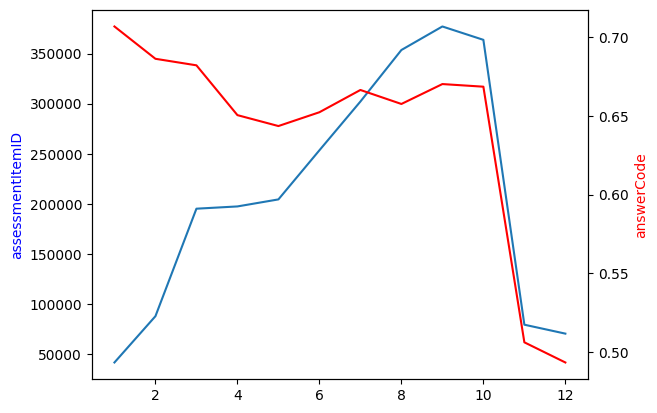

In [108]:
graph_plot(month)

In [91]:
day = df.groupby(df["Timestamp"].dt.day).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

day
# 일자에 따른 차이가 별로 없다

,assessmentItemID,answerCode
Timestamp,,
1,60803,0.651103
2,69515,0.657340
3,79261,0.654837
4,74044,0.644536
5,66781,0.645154
6,80544,0.665338
7,87851,0.662554
8,82620,0.659162
9,76120,0.657987


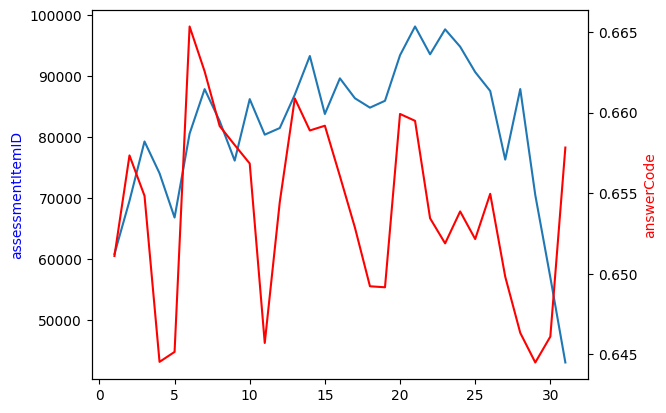

In [109]:
graph_plot(day)

In [93]:
weekday = df.groupby(df["Timestamp"].dt.weekday).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

weekday
# 요일에 따른 변화는 있어 보인다.

,assessmentItemID,answerCode
Timestamp,,
0,356518,0.675781
1,510739,0.667045
2,422974,0.641120
3,494501,0.657922
4,431405,0.643650
5,174192,0.603369
6,136371,0.674146


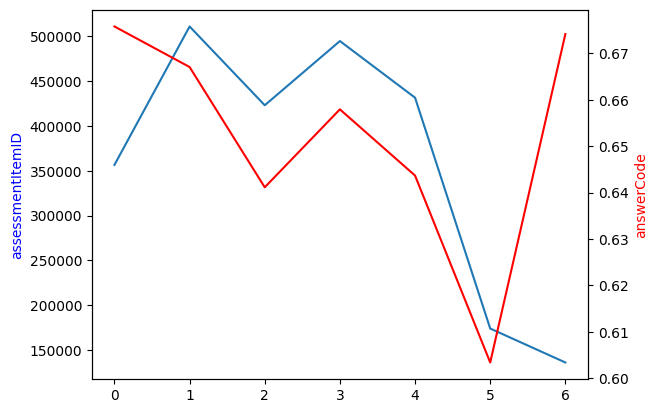

In [110]:
graph_plot(weekday)

In [95]:
hour = df.groupby(df["Timestamp"].dt.hour).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

hour
# 시간대 별 정답률의 차이가 있어보임

,assessmentItemID,answerCode
Timestamp,,
0,112557,0.650462
1,153228,0.644876
2,176343,0.642090
3,159047,0.633329
4,166435,0.633352
5,182822,0.624684
6,186410,0.628330
7,184748,0.641452
8,175819,0.669495


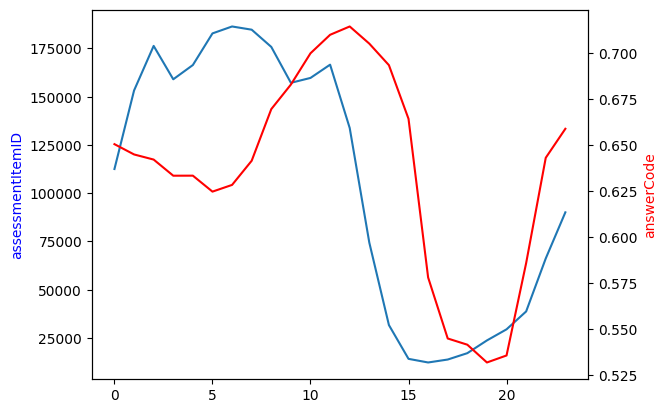

In [111]:
graph_plot(hour)

In [97]:
min = df.groupby(df["Timestamp"].dt.minute).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

min
# 풀었던 분에 따른 정답률의 차이가 없어보임, 초도 마찬가지 

,assessmentItemID,answerCode
Timestamp,,
0,41249,0.651434
1,40831,0.657001
2,41453,0.649603
3,41570,0.650854
4,41489,0.656319
5,41349,0.656195
6,41284,0.659989
7,41988,0.648947
8,41957,0.656196


KnowledageTag에 대한 EDA

<Axes: xlabel='KnowledgeTag', ylabel='answerCode'>

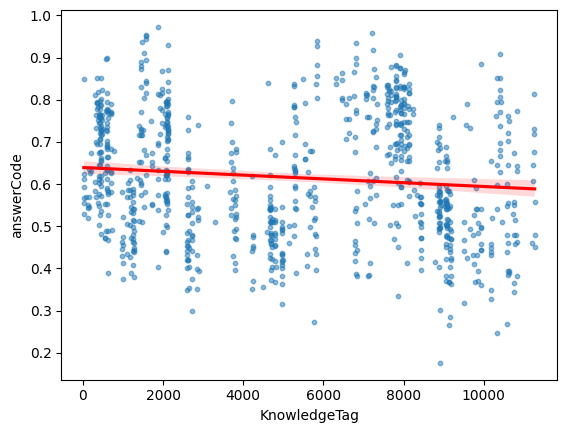

In [68]:
tag_groupby = df[df['answerCode'] != -1].groupby(['KnowledgeTag']).agg({
    'KnowledgeTag' : 'count',
    'answerCode' : percentile
})

sns.regplot(
    tag_groupby, 
    x = tag_groupby.index,
    y = "answerCode",
    scatter_kws={
        's':10,
        'alpha':0.5,
    },
    line_kws={'color':'r'}
)

# Tag에 따라 정답률의 차이는 있음
# Tag 번호가 커지고 작아짐에 따른 정답률의 차이는 없어보인다.
# 추가적인 FE가 필요할 것 같음 => user가 푼 Tag간 정답률의 차이..?